# Synthetic inversion

## import packages

In [1]:
%load_ext autoreload
%autoreload 2
%load_ext snakeviz

import sys

sys.path.insert(1, "../")

import RIS_gravity_inversion.inversion as inv
import RIS_gravity_inversion.plotting as plots
import RIS_gravity_inversion.utils as inv_utils

from antarctic_plots import utils, regions, maps, fetch, profile
import numpy as np
import pandas as pd
import xarray as xr
import matplotlib.pyplot as plt
import verde as vd
import scipy as sp
import pvxarray
import rioxarray
import pygmt
import os

c:\Users\matthewt\AppData\Local\miniforge3\envs\RIS_gravity_inversion\lib\site-packages\xarray\backends\cfgrib_.py:29: UserWarning: Failed to load cfgrib - most likely there is a problem accessing the ecCodes library. Try `import cfgrib` to get the full error message
  warnings.warn(
PROJ: proj_create_from_database: Cannot find proj.db


# Synthetic model

## flat upper layer

In [2]:
spacing = 5e3
inversion_region = (-250e3, -50e3, -50e3, 150e3)
buffer_region = utils.alter_region(inversion_region, buffer=40e3)[1]

# create grid of coordinates
coords = vd.grid_coordinates(region=buffer_region, spacing=spacing)

# create xarray dataarray from coordinates with a constant value of -200m
layer1 = vd.make_xarray_grid(
    coords, np.ones_like(coords[0]) * -200, data_names="z", dims=("y", "x")
).z
layer1 = fetch.resample_grid(
    layer1, spacing=spacing, region=buffer_region, registration="g"
)
utils.get_grid_info(layer1)

returning original grid


(5000.0, [-290000.0, -10000.0, -90000.0, 190000.0], -200.0, -200.0, 'g')

## bathymetry layer

returning original grid


(5000.0,
 [-290000.0, -10000.0, -90000.0, 190000.0],
 -2647.8449707,
 -2006.44543457,
 'g')

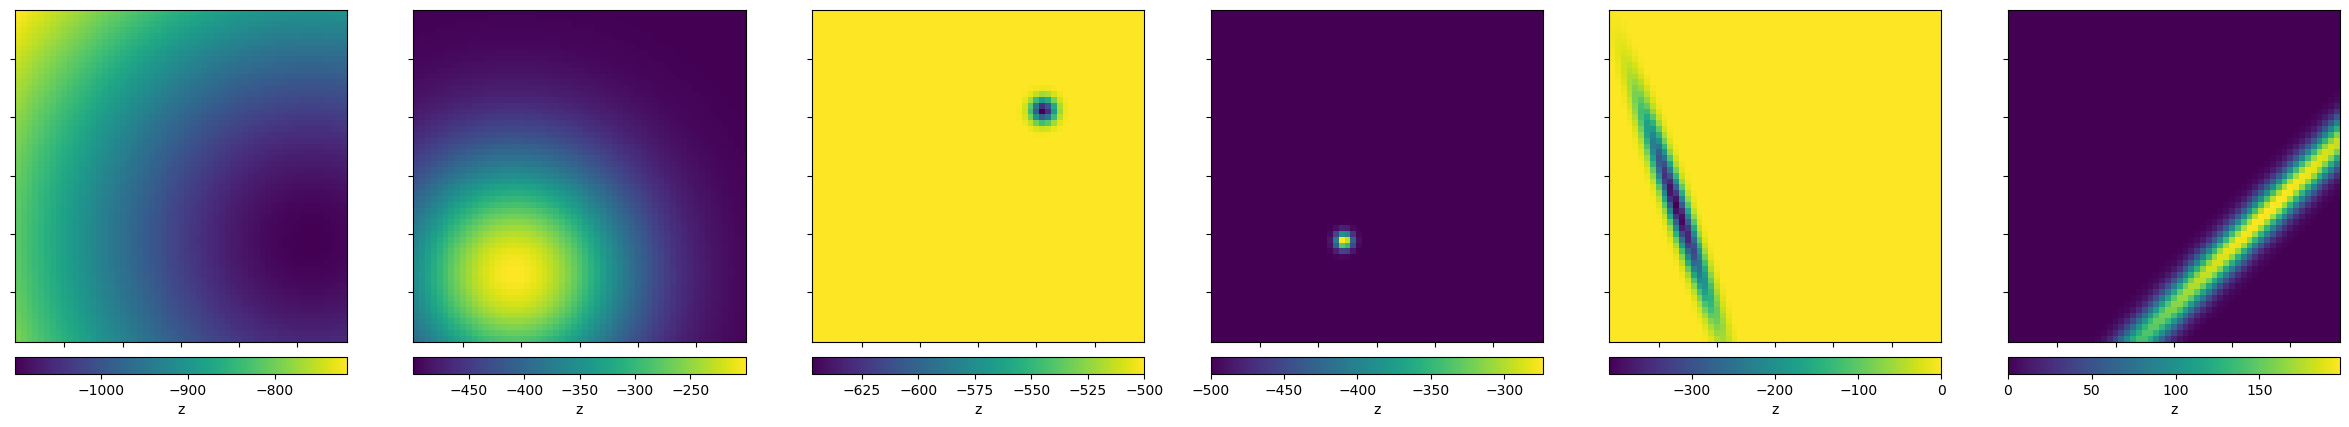

In [3]:
layer2 = inv_utils.synthetic_topography(
    spacing,
    buffer_region,
    plot_individuals=True,
)
layer2 = fetch.resample_grid(
    layer2, spacing=spacing, region=buffer_region, registration="g"
)
utils.get_grid_info(layer2)

## base layer

returning original grid


(5000.0,
 [-290000.0, -10000.0, -90000.0, 190000.0],
 -4581.79833984,
 -3292.77416992,
 'g')

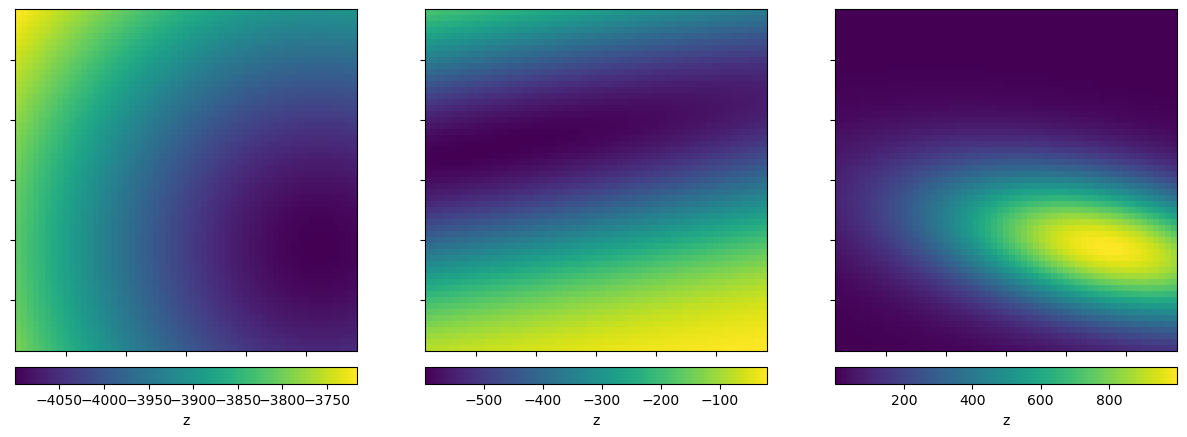

In [4]:
layer3 = inv_utils.synthetic_topography_simple(
    spacing,
    buffer_region,
    plot_individuals=True,
)
layer3 = fetch.resample_grid(
    layer3, spacing=spacing, region=buffer_region, registration="g"
)
utils.get_grid_info(layer3)

In [5]:
# fig = maps.plot_grd(
#     layer1,
#     fig_height=10,
#     title='Layer 1 (water surface)',
#     cpt_lims=(-250, -150),
#     cbar_label='elevation (m)',
#     frame=["nSWe", "xaf10000", "yaf10000"],
#     show_region=inversion_region,
#     )

# fig = maps.plot_grd(
#     layer2,
#     fig_height=10,
#     title='Layer 2 (bathymetry surface)',
#     hist=True,
#     cbar_yoffset=3,
#     grd2_cpt=True,
#     cbar_label='elevation (m)',
#     frame=["nSwe", "xaf10000", "yaf10000"],
#     show_region=inversion_region,
#     fig=fig,
#     origin_shift="xshift",
#     )

# fig = maps.plot_grd(
#     layer3,
#     fig_height=10,
#     title='Layer 3 (basement surface)',
#     hist=True,
#     cbar_yoffset=3,
#     grd2_cpt=True,
#     cbar_label='elevation (m)',
#     frame=["nSwE", "xaf10000", "yaf10000"],
#     show_region=inversion_region,
#     fig=fig,
#     origin_shift="xshift",
#     )

# fig.show()

## visualize in 3d

In [6]:
# # set crs
# layer2 = layer2.rio.set_crs("EPSG:3031")

# # turn into pyvista mesh
# mesh = layer2.pyvista.mesh(x="x", y="y")

# # Warp top and plot in 3D
# mesh.warp_by_scalar(
#     factor=100,
# ).plot(
#     show_edges=True,
#     )

In [7]:
# # set crs
# layer3 = layer3.rio.set_crs("EPSG:3031")

# # turn into pyvista mesh
# mesh = layer3.pyvista.mesh(x="x", y="y")

# # Warp top and plot in 3D
# mesh.warp_by_scalar(
#     factor=100,
# ).plot(
#     show_edges=True,
#     )

# Observed gravity
use this synthetic model to create a synthethic gravity survey. This synthetic gravity anomaly will have both regional and short-wavelength signals, from the base layer and bathymetry layer, respectively.

## make a dictionary of properties

In [8]:
layers = {
    "layer1": {
        "spacing": spacing,
        "rho": 1030,
        "grid": layer1,
    },
    "layer2": {
        "spacing": spacing,
        "rho": 2300,
        "grid": layer2,
    },
    "layer3": {
        "spacing": spacing,
        "rho": 2670,
        "grid": layer3,
    },
}

## forward gravity of the model

### make a prism model

In [9]:
inv.grids_to_prism_layers(
    layers,
    registration="g",
)

# plots.plot_prism_layers(
#     layers,
#     plot_type='3D',
#     color_by='density',
#     # color_by='thickness',
#     clip_box=False,
#     # log_scale=False,
#     # layers_for_3d=['layer2', 'layer3'],
# )

********** layer3 top: -4100m and bottom: -4581m **********
********** layer2 top: -2373m and bottom: -4100m **********

********** layer1 top: -200m and bottom: -2373m **********



make pandas dataframe of locations to calculate gravity

In [10]:
# create lists of coordinates
(x, y) = vd.grid_coordinates(region=inversion_region, spacing=1e3)

# grid the coordinates with a constant height of 1km
observations = vd.make_xarray_grid(
    (x, y),
    np.ones_like(x) * 1e3,
    data_names="z",
    dims=("y", "x"),
).z
df = vd.grid_to_table(observations)

### calculate gravity of model

In [11]:
synthetic_forward = inv.forward_grav_layers(
    layers,
    df,
    exclude_layers=None,
    progressbar=True,
    parallel=True,
)
synthetic_forward.describe()
# inv.forward_grav_layers.parallel_diagnostics(level=4)
# parallel = True 1:46, 1:37, 1:39, 56s, 58s
# parallel = False 6:33

  0%|          | 0/40401 [00:00<?, ?it/s]

3249 prisms in layer1 layer
finished layer1 layer


  0%|          | 0/40401 [00:00<?, ?it/s]

3249 prisms in layer2 layer
finished layer2 layer


  0%|          | 0/40401 [00:00<?, ?it/s]

3249 prisms in layer3 layer
finished layer3 layer


,y,x,z,layer1_forward_grav,layer2_forward_grav,layer3_forward_grav,forward_total
count,40401.000000,40401.000000,40401.0,4.040100e+04,4.040100e+04,4.040100e+04,4.040100e+04
mean,50000.000000,-150000.000000,1000.0,-1.055798e-14,-8.644488e-15,-5.762992e-15,-2.521309e-14
std,58023.702054,58023.702054,0.0,4.249123e+00,3.063774e+01,3.619233e+01,8.109047e+00
min,-50000.000000,-250000.000000,1000.0,-1.124051e+01,-8.701323e+01,-4.826418e+01,-1.674984e+01
25%,0.000000,-200000.000000,1000.0,-2.869843e+00,-1.691193e+01,-3.186907e+01,-6.002526e+00
50%,50000.000000,-150000.000000,1000.0,3.830287e-01,9.469977e+00,-6.506815e+00,-9.431957e-01
75%,100000.000000,-100000.000000,1000.0,3.446470e+00,2.552903e+01,2.694724e+01,7.501790e+00
max,150000.000000,-50000.000000,1000.0,8.339357e+00,3.211914e+01,7.907613e+01,1.899203e+01


### plot the results

In [12]:
# forward_grids = plots.forward_grav_plotting(
#     synthetic_forward,
#     region=inversion_region,
#     grav_spacing=1e3,
#     registration="g",
# )

## add noise

add some noise to the forward gravity

In [13]:
synthetic_forward["grav_noisy"] = inv_utils.contaminate(
    synthetic_forward.forward_total,
    stddev=0.02,
    percent=True,
    seed=0,
)
synthetic_forward.describe()

,y,x,z,layer1_forward_grav,layer2_forward_grav,layer3_forward_grav,forward_total,grav_noisy
count,40401.000000,40401.000000,40401.0,4.040100e+04,4.040100e+04,4.040100e+04,4.040100e+04,4.040100e+04
mean,50000.000000,-150000.000000,1000.0,-1.055798e-14,-8.644488e-15,-5.762992e-15,-2.521309e-14,-2.503300e-14
std,58023.702054,58023.702054,0.0,4.249123e+00,3.063774e+01,3.619233e+01,8.109047e+00,8.116408e+00
min,-50000.000000,-250000.000000,1000.0,-1.124051e+01,-8.701323e+01,-4.826418e+01,-1.674984e+01,-1.749756e+01
25%,0.000000,-200000.000000,1000.0,-2.869843e+00,-1.691193e+01,-3.186907e+01,-6.002526e+00,-6.021161e+00
50%,50000.000000,-150000.000000,1000.0,3.830287e-01,9.469977e+00,-6.506815e+00,-9.431957e-01,-9.334268e-01
75%,100000.000000,-100000.000000,1000.0,3.446470e+00,2.552903e+01,2.694724e+01,7.501790e+00,7.485454e+00
max,150000.000000,-50000.000000,1000.0,8.339357e+00,3.211914e+01,7.907613e+01,1.899203e+01,1.955217e+01


compare the noise and noise-free

In [14]:
# grav_noise_free = synthetic_forward.set_index(["y", "x"]).to_xarray().forward_total
# grav_noisy = synthetic_forward.set_index(["y", "x"]).to_xarray().grav_noisy

# grids = utils.grd_compare(
#     grav_noise_free,
#     grav_noisy,
#     plot=True,
#     plot_type='xarray',
#     cmap="RdBu_r",
#     grid1_name="Synthetic gravity anomaly",
#     grid2_name="with noise",
#     )

## sample grid

In [15]:
# set coordinates of observation points
grav_spacing = 5e3
coords = vd.grid_coordinates(region=inversion_region, spacing=grav_spacing)
# turn coordinates into dataframe
grav = vd.make_xarray_grid(
    coords, data=np.ones_like(coords[0]) * 1e3, data_names="z", dims=("y", "x")
)
grav = vd.grid_to_table(grav)

# grid the synthetic gravity data
synthetic_gravity = synthetic_forward.set_index(["y", "x"]).to_xarray().grav_noisy

# sample the noisy data at the observation points
grav = profile.sample_grids(grav, synthetic_gravity, "Gobs")
grav

,y,x,z,Gobs
0,-50000.0,-250000.0,1000.0,7.631487
1,-50000.0,-245000.0,1000.0,7.447865
2,-50000.0,-240000.0,1000.0,8.502273
3,-50000.0,-235000.0,1000.0,8.986354
4,-50000.0,-230000.0,1000.0,8.022787
...,...,...,...,...
1676,150000.0,-70000.0,1000.0,-13.068657
1677,150000.0,-65000.0,1000.0,-13.467841
1678,150000.0,-60000.0,1000.0,-14.237309
1679,150000.0,-55000.0,1000.0,-14.656716


grid the sampled points

In [16]:
Gobs = pygmt.surface(
    data=grav[["x", "y", "Gobs"]],
    region=inversion_region,
    spacing=grav_spacing,
    registration="g",
    T=0.25,
    verbose="q",
)

c:\Users\matthewt\AppData\Local\miniforge3\envs\RIS_gravity_inversion\lib\site-packages\xarray\backends\plugins.py:64: RuntimeWarning: Engine 'cfgrib' loading failed:
Cannot find the ecCodes library
  warnings.warn(f"Engine {name!r} loading failed:\n{ex}", RuntimeWarning)


plot synthetic gravity anomaly

In [17]:
# # plot the synthetic gravity anomaly grid
# fig = maps.plot_grd(
#     synthetic_gravity,
#     region=buffer_region,
#     fig_height=10,
#     cmap="balance+h0",
#     title='Synthetic gravity anomaly',
#     cbar_label='mGal',
#     frame=["nSWe", "xaf10000", "yaf10000"],
#     show_region=inversion_region,
#     hist=True,
#     cbar_yoffset=3,
#     grd2_cpt=True,
#     )

# # plot observation points
# fig.plot(grav[['x','y']], style="c.05c", color="black")

# # plot the synthetic observed gravity grid
# fig = maps.plot_grd(
#     Gobs,
#     region=buffer_region,
#     fig_height=10,
#     cmap="balance+h0",
#     title='Snythetic observed gravity',
#     cbar_label='mGal',
#     frame=["nSwE", "xaf10000", "yaf10000"],
#     show_region=inversion_region,
#     hist=True,
#     cbar_yoffset=3,
#     grd2_cpt=True,
#     fig=fig,
#     origin_shift='xshift',
#     )

# fig.show()

re-format the dataframe

In [18]:
grav = grav[["x", "y", "Gobs", "z"]]
grav

,x,y,Gobs,z
0,-250000.0,-50000.0,7.631487,1000.0
1,-245000.0,-50000.0,7.447865,1000.0
2,-240000.0,-50000.0,8.502273,1000.0
3,-235000.0,-50000.0,8.986354,1000.0
4,-230000.0,-50000.0,8.022787,1000.0
...,...,...,...,...
1676,-70000.0,150000.0,-13.068657,1000.0
1677,-65000.0,150000.0,-13.467841,1000.0
1678,-60000.0,150000.0,-14.237309,1000.0
1679,-55000.0,150000.0,-14.656716,1000.0


# Invert to recover full-res starting model

## create random constraint points

In [19]:
coords = vd.scatter_points(region=inversion_region, size=40, random_state=3)
constraint_points = pd.DataFrame(data={"x": coords[0], "y": coords[1]})

## create starting bathymetry layer

In [20]:
# Method #1
df = constraint_points.copy()
df = profile.sample_grids(df, layer2, "z")
starting_bathymetry = pygmt.surface(
    data=df,
    region=buffer_region,
    spacing=grav_spacing,
    registration="g",
    T=0.25,
    verbose="q",
)

# Method #2
# layer2_filtered = pygmt.grdfilter(layer2, filter="g100e3", distance="0")

# compare starting and actual bathymetry grids
# grids = utils.grd_compare(
#     layer2,
#     starting_bathymetry,
#     plot=True,
#     plot_type='xarray',
#     grid1_name="true bathymetry",
#     grid2_name="bathymetry sampled from constraints",
#     )

# plt.plot(df.x, df.y, "k+")

## make a new layers dict

In [21]:
inv_layers = {
    "water": {
        "spacing": spacing,
        "rho": 1030,
        "grid": layer1,
    },
    "bathymetry": {
        "spacing": spacing,
        "rho": 2300,
        "grid": starting_bathymetry,
    },
}

## plot inputs

In [22]:
active_layer = "bathymetry"

# plots.plot_inputs(
#     (inv_layers, grav, None, constraint_points, None),
#     grav_spacing = grav_spacing,
#     active_layer = active_layer,
#     inversion_region = inversion_region,
#     # plot_type='pygmt',
#     plot_type='xarray',
#     registration="g",
#     # kwargs
#     plotting_constraints=constraint_points,
#     constraint_size=4
# )

## make prism layers

In [23]:
inv.grids_to_prism_layers(
    inv_layers,
    # thickness_threshold=100,
    registration="g",
)

# plots.plot_prism_layers(
#     inv_layers,
#     cmap='viridis',
#     # plot_type='3D',
#     layers_for_3d = [active_layer],
#     # color_by='density',
#     color_by='thickness',
#     clip_box=False,
#     log_scale=False,
# )

********** bathymetry top: -2366m and bottom: -2652m **********
********** water top: -200m and bottom: -2366m **********



## forward gravity

In [24]:
df_forward = inv.forward_grav_layers(
    inv_layers,
    grav,
    progressbar=True,
    parallel=True,
)

# forward_grids = plots.forward_grav_plotting(
#     df_forward,
#     region=inversion_region,
#     grav_spacing=grav_spacing,
#     registration='g',
#     # kwargs
#     # plot_dists = True,
# )

df_forward.describe()

  0%|          | 0/1681 [00:00<?, ?it/s]

3249 prisms in water layer
finished water layer


  0%|          | 0/1681 [00:00<?, ?it/s]

3249 prisms in bathymetry layer
finished bathymetry layer


,x,y,Gobs,z,water_forward_grav,bathymetry_forward_grav,forward_total
count,1681.000000,1681.000000,1681.000000,1681.0,1.681000e+03,1.681000e+03,1.681000e+03
mean,-150000.000000,50000.000000,-0.140189,1000.0,2.164175e-15,-5.410438e-16,1.623132e-15
std,59178.402592,59178.402592,8.131955,0.0,4.738956e+00,1.046683e+01,5.759061e+00
min,-250000.000000,-50000.000000,-16.971684,1000.0,-1.294966e+01,-1.705018e+01,-1.080558e+01
25%,-200000.000000,0.000000,-6.201912,1000.0,-3.390069e+00,-9.204569e+00,-4.944380e+00
50%,-150000.000000,50000.000000,-1.090943,1000.0,4.174163e-01,-6.761861e-01,-3.011458e-01
75%,-100000.000000,100000.000000,7.408885,1000.0,4.238461e+00,7.798122e+00,4.457900e+00
max,-50000.000000,150000.000000,18.439735,1000.0,6.739793e+00,2.581078e+01,1.286112e+01


## anomalies

In [25]:
filter = "g300e3"
trend = 2
constraints = constraint_points
eq_sources = 50000e3

# regional_method="filter"
# title= f"Method: {regional_method} ({filter})"

# regional_method="trend"
# title= f"Method: {regional_method} (order={trend})"

# regional_method="constraints"
# title= f"Method: {regional_method} (numb constraints={len(constraints)})"

regional_method = "eq_sources"
title = f"Method: {regional_method} (Source depth={int(eq_sources/1e3)}km)"

df_anomalies = inv.anomalies(
    layers=inv_layers,
    input_grav=df_forward,
    grav_spacing=grav_spacing,
    registration="g",
    regional_method=regional_method,
    inversion_region=inversion_region,
    crs="3031",
    # filter kwargs
    filter=filter,
    # trend kwargs
    trend=trend,
    fill_method="pygmt",
    # fill_method='rioxarray',
    # constraint kwargs
    constraints=constraints,
    tension_factor=0.25,
    # eq sources kwargs
    eq_sources=eq_sources,
    depth_type="relative",
    eq_damping=None,
    block_size=grav_spacing,
)

# anom_grids = plots.anomalies_plotting(
#     df_anomalies,
#     region=inversion_region,
#     grav_spacing=grav_spacing,
#     title=title,
#     registration="g",
#     # constraints=constraints,
#     # plot_dists=True,
#     # plot_power_spectrums=True,
# )

df_anomalies.describe()

no bouguer corrections applied


,x,y,Gobs,z,water_forward_grav,bathymetry_forward_grav,forward_total,grav_corrected,misfit,reg,res
count,1681.000000,1681.000000,1681.000000,1681.0,1.681000e+03,1.681000e+03,1.681000e+03,1681.000000,1681.000000,1681.000000,1681.000000
mean,-150000.000000,50000.000000,-0.140189,1000.0,2.164175e-15,-5.410438e-16,1.623132e-15,-0.140189,-0.140189,0.096766,-0.236956
std,59178.402592,59178.402592,8.131955,0.0,4.738956e+00,1.046683e+01,5.759061e+00,8.131955,5.755277,4.399227,3.674496
min,-250000.000000,-50000.000000,-16.971684,1000.0,-1.294966e+01,-1.705018e+01,-1.080558e+01,-16.971684,-15.179392,-12.573227,-12.446053
25%,-200000.000000,0.000000,-6.201912,1000.0,-3.390069e+00,-9.204569e+00,-4.944380e+00,-6.201912,-4.181971,-3.433914,-2.639629
50%,-150000.000000,50000.000000,-1.090943,1000.0,4.174163e-01,-6.761861e-01,-3.011458e-01,-1.090943,-2.011749,0.006271,-0.221179
75%,-100000.000000,100000.000000,7.408885,1000.0,4.238461e+00,7.798122e+00,4.457900e+00,7.408885,4.043447,3.667114,2.265120
max,-50000.000000,150000.000000,18.439735,1000.0,6.739793e+00,2.581078e+01,1.286112e+01,18.439735,16.342832,8.467712,10.318362


## inversion

In [127]:
# %%snakeviz --new-tab

topo_results, grav_results, layers_update = inv.geo_inversion(
    active_layer=active_layer,
    layers_dict=inv_layers,
    input_grav=df_anomalies,
    buffer_region=buffer_region,
    regional_method=regional_method,
    grav_spacing=grav_spacing,
    l2_norm_tolerance=1,
    delta_l2_norm_tolerance=0.6,
    Max_Iterations=3,
    registration="g",
    # deriv_type="annulus",
    deriv_type="prisms",
    # solver_type="least squares",
    solver_type="verde least squares",
    # solver_damping=1e3,
    # apply_weights=True,
    max_layer_change_per_iter=100,
    # save_results = True,
    # kwargs
    apply_constraints=False,
    # filter kwargs
    filter=filter,
    # trend kwargs
    trend=trend,
    fill_method="pygmt",
    # fill_method='rioxarray',
    # constraint kwargs
    constraints=constraints,
    # tension_factor=1,
    # eq sources kwargs
    eq_sources=eq_sources,
    depth_type="relative",
    eq_damping=None,
    block_size=grav_spacing,
    # fname_topo = "topo_results_5k_constraints_base",
    # fname_gravity = "gravity_results_5k_constraints_base",
)
#  45s, 52s,

[autoreload of RIS_gravity_inversion.inversion failed: Traceback (most recent call last):
  File "c:\Users\matthewt\AppData\Local\miniforge3\envs\RIS_gravity_inversion\lib\site-packages\IPython\extensions\autoreload.py", line 261, in check
    superreload(m, reload, self.old_objects)
  File "c:\Users\matthewt\AppData\Local\miniforge3\envs\RIS_gravity_inversion\lib\site-packages\IPython\extensions\autoreload.py", line 484, in superreload
    update_generic(old_obj, new_obj)
  File "c:\Users\matthewt\AppData\Local\miniforge3\envs\RIS_gravity_inversion\lib\site-packages\IPython\extensions\autoreload.py", line 381, in update_generic
    update(a, b)
  File "c:\Users\matthewt\AppData\Local\miniforge3\envs\RIS_gravity_inversion\lib\site-packages\IPython\extensions\autoreload.py", line 293, in update_function
    setattr(old, name, getattr(new, name))
ValueError: jacobian_annular() requires a code object with 1 free vars, not 0
]



##############################################################################################
iteration 1
initial misfit RMSE = 3.68 mGal
initial L2-norm : 1.92
initial delta L2-norm : inf


c:\Users\matthewt\AppData\Local\miniforge3\envs\RIS_gravity_inversion\lib\site-packages\verde\base\least_squares.py:57: UserWarning: Under-determined problem detected (ndata, nparams)=(1681, 3249).
  warn(


Layer correction mean: 14 m, RMSE: 1697 m
constraints not applied
updating forward gravity


xyz2grd [WARNING]: 82 values gave bad indices: Pixel vs Gridline registration confusion?


updating the misfits
no bouguer corrections applied

updated misfit RMSE: 2.39
updated L2-norm: 1.55,  tolerance: 1
updated delta L2-norm : 1.24,  tolerance: 0.6

##############################################################################################
iteration 2
initial misfit RMSE = 2.39 mGal
initial L2-norm : 1.55
initial delta L2-norm : 1.24


c:\Users\matthewt\AppData\Local\miniforge3\envs\RIS_gravity_inversion\lib\site-packages\verde\base\least_squares.py:57: UserWarning: Under-determined problem detected (ndata, nparams)=(1681, 3249).
  warn(


Layer correction mean: 122 m, RMSE: 1403 m
constraints not applied
updating forward gravity


xyz2grd [WARNING]: 82 values gave bad indices: Pixel vs Gridline registration confusion?


updating the misfits
no bouguer corrections applied

updated misfit RMSE: 1.7
updated L2-norm: 1.3,  tolerance: 1
updated delta L2-norm : 1.19,  tolerance: 0.6

##############################################################################################
iteration 3
initial misfit RMSE = 1.7 mGal
initial L2-norm : 1.3
initial delta L2-norm : 1.19


c:\Users\matthewt\AppData\Local\miniforge3\envs\RIS_gravity_inversion\lib\site-packages\verde\base\least_squares.py:57: UserWarning: Under-determined problem detected (ndata, nparams)=(1681, 3249).
  warn(


Layer correction mean: 152 m, RMSE: 1167 m
constraints not applied
updating forward gravity


xyz2grd [WARNING]: 82 values gave bad indices: Pixel vs Gridline registration confusion?


updating the misfits
no bouguer corrections applied

updated misfit RMSE: 1.37
updated L2-norm: 1.17,  tolerance: 1
updated delta L2-norm : 1.11,  tolerance: 0.6

Inversion terminated after 3 iterations with least-squares (L2) norm = 1.171707639693818 because maximum number of iterations  (3) reached


grid regions dont match, using inner region [-250000.0, -50000.0, -50000.0, 150000.0]
returning grid with new region and/or registration, same spacing
returning original grid
returning original grid
returning original grid
returning original grid
returning original grid
returning original grid
returning original grid


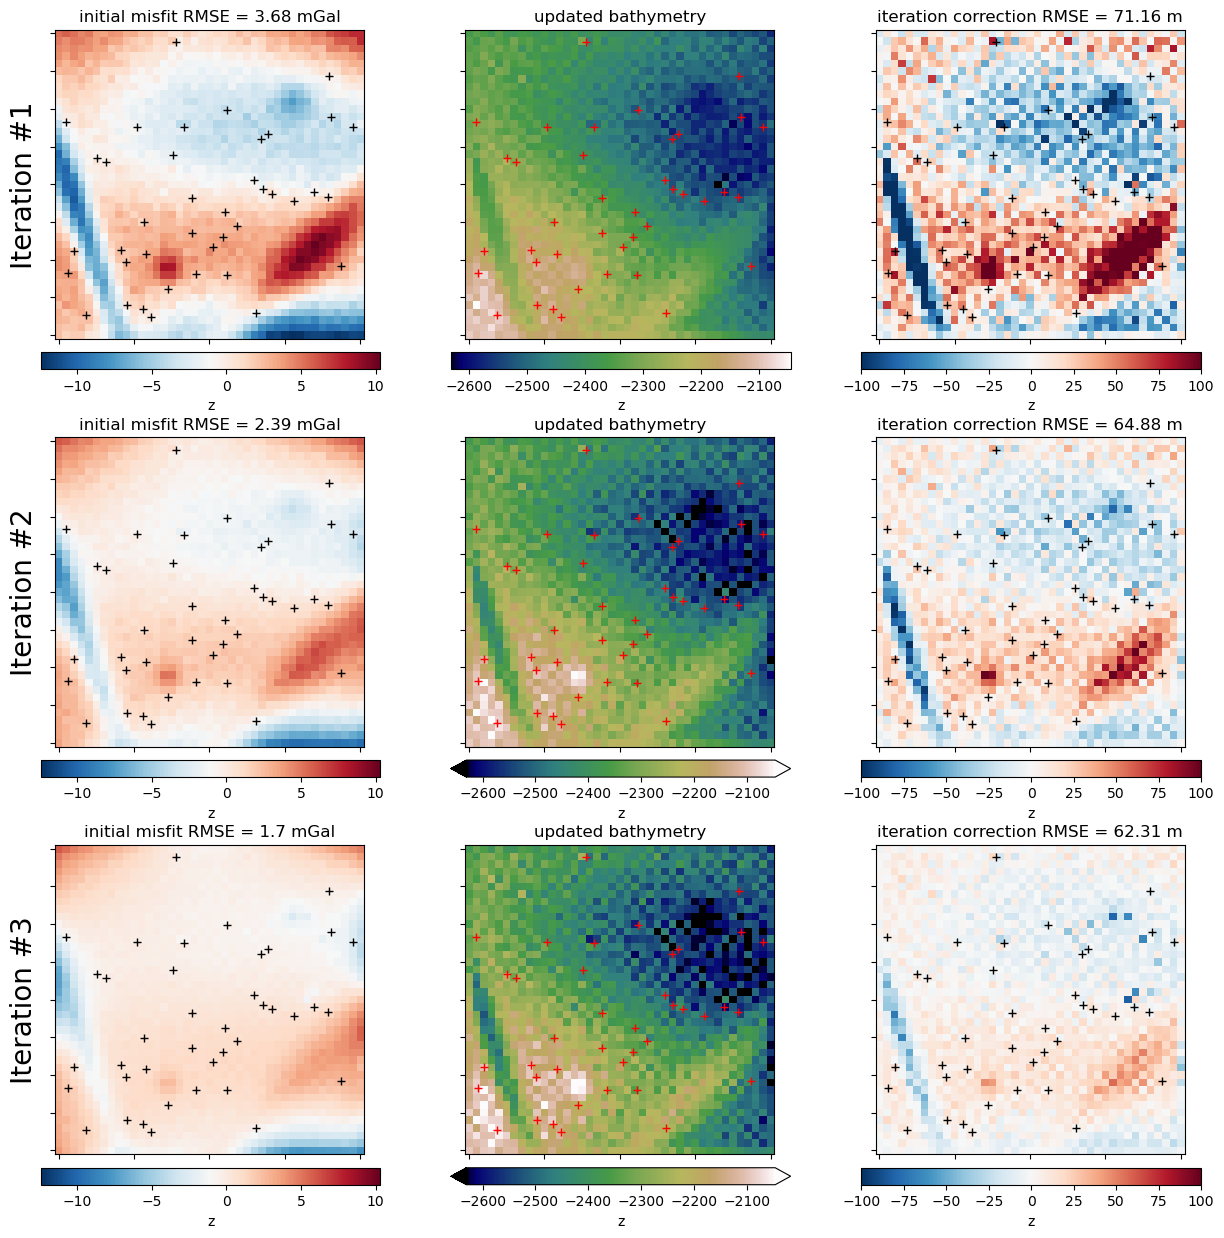

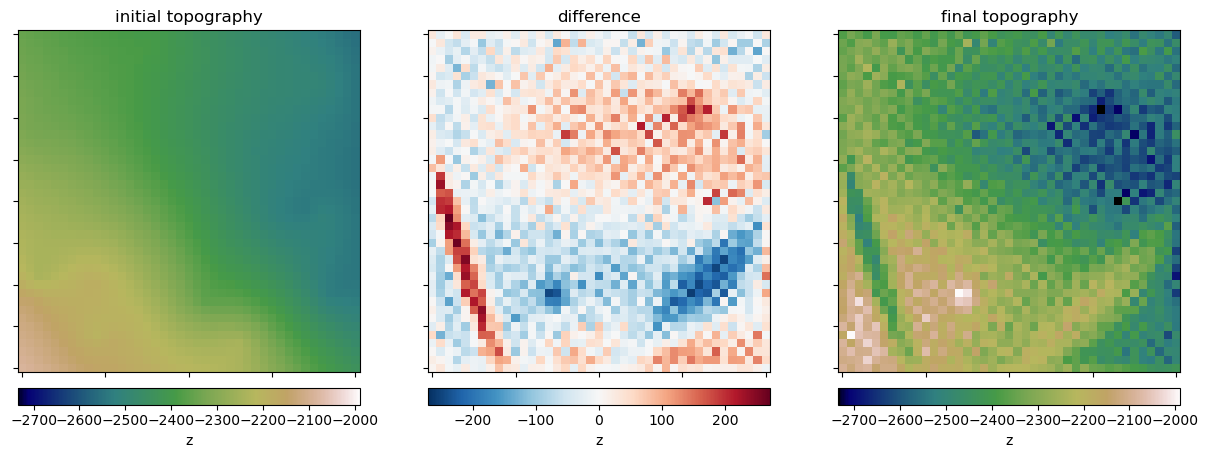

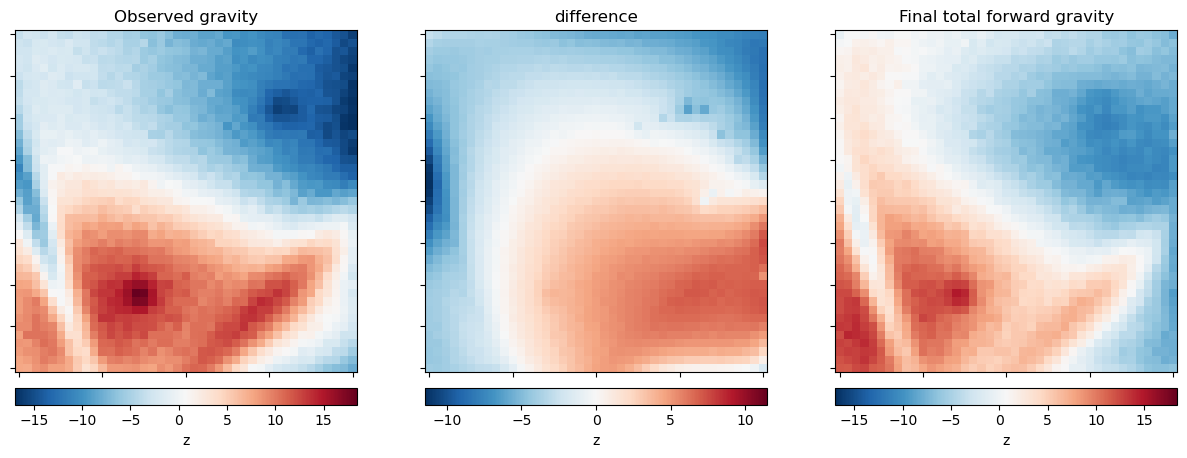

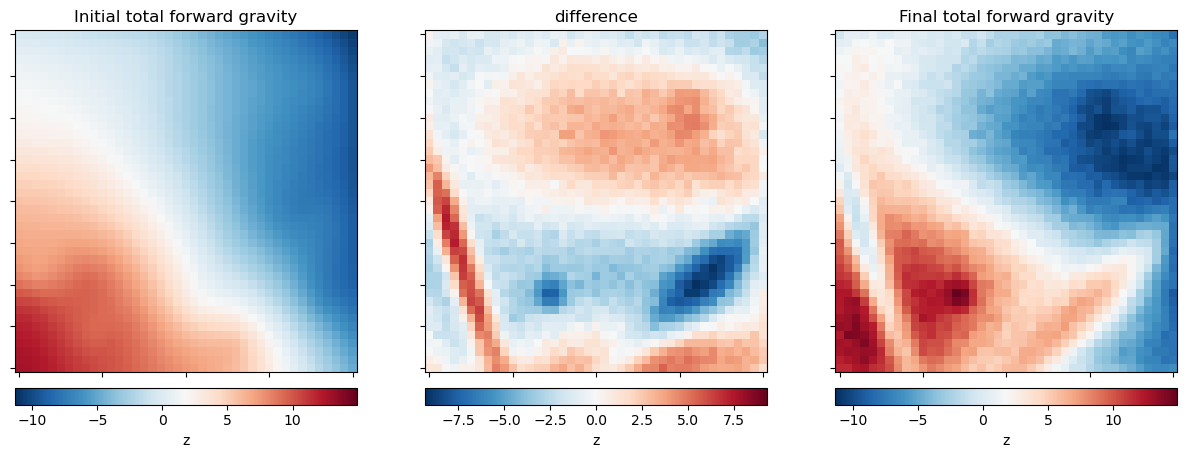

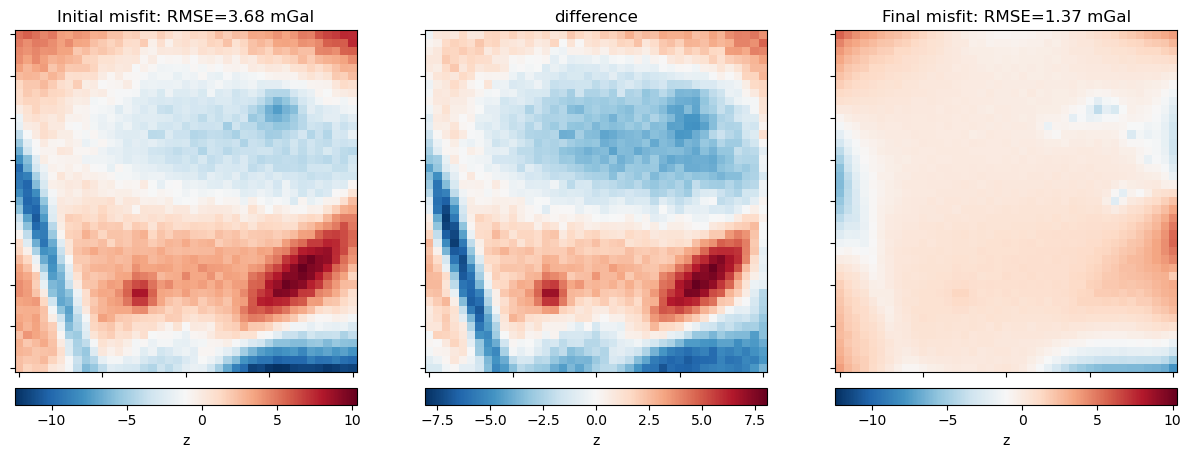

In [128]:
plots.plot_inversion_results(
    grav_results=grav_results,
    topo_results=topo_results,
    layers_dict=inv_layers,
    active_layer=active_layer,
    grav_spacing=grav_spacing,
    region=inversion_region,
    registration="g",
    # plot_iters = False,
    # plot_topo_results = False,
    # plot_grav_results = False,
    # kwargs
    constraints=constraint_points,
)

## compare inverted bathymetry to synthetic starting bathymetry

In [ ]:
grids = utils.grd_compare(
    layer2,
    layers_update[active_layer]["prisms"].top,
    region=inversion_region,
    plot=True,
    plot_type="xarray",
)

In [ ]:
# for comparision, plot some Ross Sea bathymetry data at the same scale

# RIS_region = [-580e3, 420e3, -1420e3, -420e3]

# RIS_reg = utils.alter_region(
#     starting_region=RIS_region,
#     zoom=400e3,
#     n_shift=600e3,
#     w_shift=200e3,
# )[0]

# fname = "../inversion_layers/bedmap2_bed.zarr"
# bedmap2 = xr.open_zarr(fname).to_array().squeeze()

# maps.plot_grd(
#     bedmap2,
#     inset=True,
#     inset_reg=utils.alter_region(RIS_region, zoom=-400e3)[0],
#     inset_width=.2,
#     )

# mesh = bedmap2_RIS.pyvista.mesh(x="x", y="y")

# mesh.warp_by_scalar(
#     factor=100,
# ).plot(
#     show_edges=True,
#     )